<a href="https://colab.research.google.com/github/zyang63/Die_casting_ejection/blob/main/Ejection_Force_and_Parting_Line_Analysis_Toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library installation and import

In [ ]:
%%capture
import cv2
try:
  import open3d as o3d
except ImportError:
  !pip install open3d
  import open3d as o3d
try:
  import open3d as o3d
except ImportError:
  !pip install open3d
  import open3d as o3d
try:
  import SimpleITK as sitk
except ImportError:
  !pip install SimpleITK
  import SimpleITK as sitk
!pip install numpy==1.24.4
import numpy as np
try:
  from stl import mesh
except ImportError:
  !pip install numpy-stl
  from stl import mesh
try:
  from scipy import ndimage
except ImportError:
  !pip install scipy
  from scipy import ndimage
try:
  from google.colab import files
  IN_COLAB = True
except ImportError:
  IN_COLAB = False
!pip install pillow

In [ ]:
import os
import math
import base64
import subprocess
import urllib.request
from IPython.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
from PIL import Image, ImageDraw

In [ ]:
%%capture
if IN_COLAB:
  blender_url_dict = {'4.2': "https://download.blender.org/release/Blender4.2/blender-4.2.0-linux-x64.tar.xz"}
  blender_version = '4.2'
  blender_url = blender_url_dict[blender_version]
  base_url = os.path.basename(blender_url)
  !mkdir $blender_version
  !wget -nc $blender_url
  !tar -xkf $base_url -C ./$blender_version --strip-components=1
else:
  blender_path = r'C:\Program Files\Blender Foundation\Blender 4.2\blender.exe'

# Geometry import from GitHub

In [ ]:
url = "https://raw.githubusercontent.com/zyang63/Die_casting_ejection/main/Casting_Shot%20-%208M0111257-1.STL"
file = "Casting_Shot_8M0111257-1.STL"
urllib.request.urlretrieve(url, file)
print(f"Downloaded file: {file}")

Downloaded file: Casting_Shot_8M0111257-1.STL


In [ ]:
url = "https://raw.githubusercontent.com/zyang63/Die_casting_ejection/main/Heatsink_Demo.stl"
file = "Heatsink_Demo.stl"
urllib.request.urlretrieve(url, file)
print(f"Downloaded file: {file}")

Downloaded file: Heatsink_Demo.stl


In [ ]:
#@title Element Count Setup { display-mode: "form", run: "auto" }
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
    filename = "/content/Casting_Shot_8M0111257-1.STL"#@param {type:"string"}
except ImportError:
    IN_COLAB = False
    filename = os.path.join(os.getcwd(), file)
element_count = 150 #@param {type:"slider", min:10, max:500, step:1}
geometry = o3d.io.read_triangle_mesh(os.path.join(os.getcwd(),filename))
max_boundary_size = (geometry.get_max_bound()-geometry.get_min_bound()).max()
mid_boundary_size = np.median(geometry.get_max_bound() - geometry.get_min_bound())
voxel_size = max_boundary_size/element_count
print("Element size is in units from stl file ",voxel_size, " per cell")
origin = geometry.get_min_bound()

Element size is in units from stl file  1.180522740681966  per cell


# Parameter setting
### "Mu" is the friction coefficent
### "rotation_angle" is specified angle setting in ejection direction optimization
### "unit" defaults to meters; for 1 mm, use unit = 0.001.   

In [ ]:
rotation_angle = 90
Mu = 0.6
unit = 1 #0.001

In [ ]:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
    base_path = "/content/"
except ImportError:
    IN_COLAB = False
    base_path = os.getcwd() + os.sep
obj_file_path = os.path.join(base_path, "remeshed_uv.obj")
blender_file_path = os.path.join(base_path, "meshed_geometry.blend")
cosine_map_path = os.path.join(base_path, "cosine_map.png")
angle_map_path = os.path.join(base_path, "angle_map.png")
ejection_coefficient_map_path = os.path.join(base_path, "ejection_coefficient_map.png")
parting_line_map_path = os.path.join(base_path, "parting_line_map.png")
ejection_coefficient_mark_map_path = os.path.join(base_path, "ejection_coefficient_mark_map.png")
cosine_result_path = os.path.join(base_path, "colored_cosine.glb")
angle_result_path = os.path.join(base_path, "colored_angle.glb")
ejection_coefficient_result_path = os.path.join(base_path, "colored_ejection_coefficient.glb")
parting_line_result_path = os.path.join(base_path, "colored_parting_line.glb")
ejection_coefficient_mark_result_path = os.path.join(base_path, "colored_ejection_coefficient_mark.glb")

# Geometric preparation
### The STL file is imported into Blender, where it undergoes remeshing and unwrapping before being exported as an OBJ file.

In [ ]:
with open('geometric_preparation.py', 'w') as f:
  code = f"""
import bpy
bpy.ops.wm.read_factory_settings(use_empty=True)
bpy.ops.wm.stl_import(filepath= "{filename}", global_scale = {unit})
obj = bpy.context.object
obj.data = obj.data.copy()
bpy.ops.object.modifier_add(type='REMESH')
bpy.context.object.modifiers["Remesh"].mode = 'VOXEL'
bpy.context.object.modifiers["Remesh"].voxel_size = {voxel_size} * {unit}
bpy.ops.object.modifier_apply(modifier="Remesh")
bpy.ops.object.mode_set(mode='EDIT')
bpy.ops.mesh.select_all(action='SELECT')
bpy.ops.uv.smart_project()
bpy.ops.object.mode_set(mode='OBJECT')
selected_object = bpy.context.object
for obj in bpy.context.selected_objects:
    if obj.type == "MESH":
        bpy.ops.wm.obj_export(filepath= "{obj_file_path}", export_triangulated_mesh=False, export_materials=False)
bpy.ops.wm.save_as_mainfile(filepath = "{blender_file_path}")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P geometric_preparation.py
else:
  python_script = r'geometric_preparation.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")

Blender 4.2.0 (hash a51f293548ad built 2024-07-16 06:27:02)
STL Importer: 8 degenerate triangles were removed
Timer 'STL Import' took 460.18 ms
Writing to /content/remeshed_uv.obj
OBJ export of 'remeshed_uv.obj' took 143.40 ms
Info: Total files 0 | Changed 0 | Failed 0
Info: Saved "meshed_geometry.blend"

Blender quit


# OBJ file processing
### After exporting the remeshed and unwrapped geometry as an OBJ file, this OBJ file and extracts its geometric components which include vertices, faces, vt_coordinates, and vt_faces.

In [ ]:
def process_obj(obj_file_path):
    vertices, faces, vt_coordinates, vt_faces = [], [], [], []
    with open(obj_file_path, 'r') as obj_file:
        for line in obj_file:
            parts = line.split()
            if parts[0] == 'v':
                vertices.append(list(map(float, parts[1:4])))
            elif parts[0] == 'f':
                f, vt_f = zip(*((int(x.split('/')[0]) - 1, int(x.split('/')[1]) - 1) for x in parts[1:]))
                faces.append(f), vt_faces.append(vt_f)
            elif parts[0] == 'vt':
                vt_coordinates.append(list(map(float, parts[1:])))
    return vertices, faces, vt_coordinates, vt_faces

In [ ]:
vertices, faces, vt_coordinates, vt_faces = process_obj(obj_file_path)

# Ejection coefficient calculation
### $\phi = \frac{F_e}{P_c} = nA_f (\mu \sin\alpha - \cos\alpha)$

Where:

- $n$ represents the number of mesh facets  
- $A_f$ denotes the area of each mesh facet  
- $\alpha$ is the angle between the ejection force and the normal force  
- $\mu$ is the friction coefficient  
- $F_e$ is the ejection force  
- $P_c$ is the contact pressure

In [ ]:
def ejection_coefficient_calculation(selected_axis_data, vertices, faces, Mu, unit):
    direction, num_eject_faces = np.array(selected_axis_data), 0
    angle_list, cosine_list, a_list, Phi_list = [], [], [], []
    for face in faces:
        normal = np.cross(*(np.array(vertices[face[i]]) - np.array(vertices[face[0]]) for i in (1, 2)))
        cosine = np.dot(normal / np.linalg.norm(normal), direction / np.linalg.norm(direction))
        cosine_list.append(cosine)
        theta = np.arccos(cosine)
        angle_list.append(theta)
        a = Mu * np.sqrt(1 - cosine**2) - abs(cosine)
        num_eject_faces += (- np.sqrt(Mu**2 + 1) <= a <= np.sqrt(Mu**2 + 1))
        a_list.append(a)
    Phi_list = [num_eject_faces * (unit**2) * a for a in a_list]
    return angle_list, cosine_list, Phi_list, max((Phi for Phi in Phi_list), default=None)

# Optimize ejection direction
### To determine the optimal ejection direction, a systematic approach is employed by rotating the ejection force vector around the geometry and calculating the corresponding ejection coefficient (𝜙). This process involves rotating the normal force through 360 degrees at specified angle setting along the x, y, and z axes, with the origin as the pivot point

In [ ]:
def ejection_force_rotation(rotation_angle):
    def rotation_matrix(axis, theta):
        theta = np.radians(theta)
        if axis == 'x':
            return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
        elif axis == 'y':
            return np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
        elif axis == 'z':
            return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    unique_rotations = {}
    for theta_x in range(0, 360 + rotation_angle, rotation_angle):
        for theta_y in range(0, 360 + rotation_angle, rotation_angle):
            for theta_z in range(0, 360 + rotation_angle, rotation_angle):
                rotated_vector = np.dot(rotation_matrix('x', theta_x),
                                        np.dot(rotation_matrix('y', theta_y),
                                               np.dot(rotation_matrix('z', theta_z), np.array([0, 1, 0]))))
                rotated_vector = tuple(np.where(np.abs(rotated_vector) < 0.001, 0, rotated_vector))
                unique_rotations.setdefault(rotated_vector, (theta_x, theta_y, theta_z))
    unique_angles_list = list(unique_rotations.values())
    unique_vectors_list = [list(vec) for vec in unique_rotations.keys()]
    return unique_angles_list, unique_vectors_list

In [ ]:
directions = ejection_force_rotation(rotation_angle)[1]
rotation_max_Phi = [ejection_coefficient_calculation(direction, vertices, faces, Mu, unit)[-1] for direction in directions]
#print(directions)
#print(rotation_max_Phi)

# Identified undercut
### Using a geometric approach, undercuts can be identified through a projection method. the process begins with importing an STL file of the geometry and converting it into a voxelized representation, where regions outside the geometry are represented as 0 and the interior regions as 1. The voxelized geometry is then analyzed using the projection method to identify undercut regions along the ejection direction.

In [ ]:
pcd = geometry.sample_points_uniformly(number_of_points=100000000)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size = voxel_size)
voxels = voxel_grid.get_voxels()
indices = np.stack(list(vx.grid_index for vx in voxels))
del voxels, voxel_grid, pcd
max_indices = np.max(indices, axis=0)+1
dense_array = np.zeros(max_indices, dtype=np.bool_)
for idx in indices:
    dense_array[tuple(idx)] = 1
del indices
array_pad = np.pad(dense_array.astype(bool),((2,2)),'constant')
del dense_array
array_closing = ndimage.binary_closing(array_pad, structure=ndimage.generate_binary_structure(3, 1),
iterations=1, mask=None,  border_value=0, origin=0, brute_force=False)
img = sitk.GetImageFromArray(array_closing.astype(int))
seg = sitk.ConnectedComponent(img != img[0,0,0])
img_filled = sitk.BinaryFillhole(seg!=0)
array_filled = sitk.GetArrayFromImage(img_filled)

In [ ]:
def find_undercut(array, direction):
    direction = np.round(direction / np.max(np.abs(direction))).astype(int)
    one_indices = np.argwhere(array == 1)
    visited = set()
    for start in one_indices:
        pos = tuple(start)
        if pos in visited:
            continue
        found_zero = False
        while all(0 <= pos[i] < array.shape[i] for i in range(3)):
            if pos in visited:
                break
            visited.add(pos)
            if array[pos] == 1:
                if found_zero:
                    return 1
            elif array[pos] == 0:
                found_zero = True
            pos = tuple(np.array(pos) + direction)
    return 0

In [ ]:
geometry_array = array_filled
adjusted_directions = [[round(d[0], 3), round(d[2], 3), round(d[1], 3)] for d in directions]
undercut_results = [find_undercut(geometry_array, np.array(d)) for d in adjusted_directions]
direction_mapping = {tuple(d): i for i, d in enumerate(adjusted_directions)}
for i, direction in enumerate(adjusted_directions):
    opposite_direction = tuple(-np.array(direction))
    if tuple(direction) in direction_mapping and opposite_direction in direction_mapping:
        opp_index = direction_mapping[opposite_direction]
        if undercut_results[i] == 1 or undercut_results[opp_index] == 1:
            undercut_results[i] = 1
            undercut_results[opp_index] = 1
print(undercut_results)

[0, 1, 0, 1, 1, 1]


# Ejection direction
### This direction yields the lowest ejection coefficient.

In [ ]:
min_Phi, ejection_direction = min(
    (rotation_max_Phi[i], directions[i])
    for i, val in enumerate(undercut_results) if val == 0)
angle_list, cosine_list, Phi_list_optimize, max_Phi_optimize = ejection_coefficient_calculation(ejection_direction, vertices, faces, Mu, unit)
print(ejection_direction)
print(max_Phi_optimize)

[np.float64(0.0), np.float64(-1.0), np.float64(0.0)]
48825.6


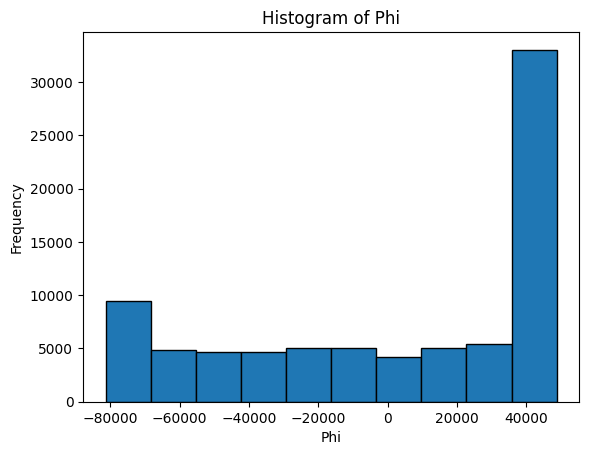

In [ ]:
plt.hist(Phi_list_optimize, bins=10, edgecolor='black')
plt.xlabel('Phi')
plt.ylabel('Frequency')
plt.title('Histogram of Phi')
plt.show()

# Mesh face angle: $\alpha$
### $\alpha$ is the angle between the ejection force and the normal force  

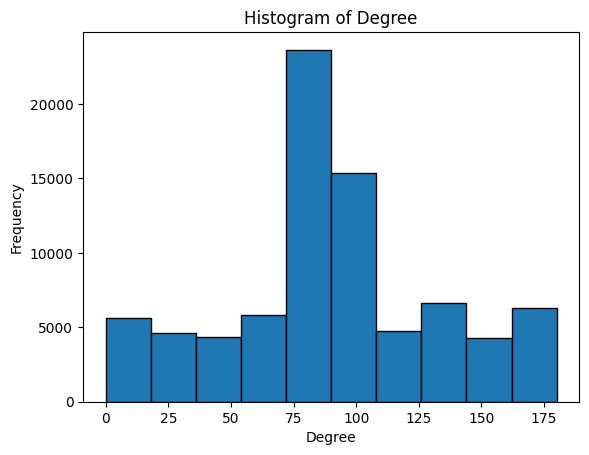

In [ ]:
degree_list = [np.degrees(x) for x in angle_list]
plt.hist(degree_list, bins=10, edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Degree')
plt.show()


In [ ]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, theta in zip(vt_faces, angle_list):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if 0 <= theta / np.pi <= 1:
            color = color_bins[min(int((theta / np.pi) * 10), 9)]
        else:
            color = (120, 120, 120)
        draw.polygon(vt_indices, outline=color, fill=color)
image.save(angle_map_path)

In [ ]:
with open('angle_result.py', 'w') as f:
  code = f"""
import bpy
bpy.ops.wm.open_mainfile(filepath = "{blender_file_path}")
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load("{angle_map_path}")
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = "{angle_result_path}")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P angle_result.py
else:
  python_script = r'angle_result.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")

Blender 4.2.0 (hash a51f293548ad built 2024-07-16 06:27:02)
Read blend: "/content/meshed_geometry.blend"
INFO Draco mesh compression is available, use library at /content/4.2/4.2/python/lib/python3.11/site-packages/libextern_draco.so
03:43:36 | INFO: Starting glTF 2.0 export
03:43:36 | INFO: Extracting primitive: Casting_Shot_8M0111257-1.001
03:43:37 | INFO: Primitives created: 1
03:43:37 | INFO: Finished glTF 2.0 export in 0.482330322265625 s


Blender quit


In [ ]:
bins = 10
colors = [(int(255 * i / (bins - 1)), 0, int(255 * (1 - i / (bins - 1)))) for i in range(bins)]
angles = [i * 180 / (bins - 1) for i in range(bins)]  # evenly spaced 0° to 180°
with open(angle_result_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()
bar_segments = "".join(
    f'<div style="height:30px; width:20px; background:#{r:02x}{g:02x}{b:02x};"></div>'
    for r, g, b in reversed(colors))
tick_labels = "".join(
    f'<div style="height:30px; font-size:12px;">α = {int(a)}°</div>'
    for a in reversed(angles))
html = f"""
<div style="display:flex; justify-content:center; align-items:center; margin-top:10px;">
  <!-- Vertical color bar + labels -->
  <div style="display:flex; flex-direction:row; align-items:center; margin-right:20px;">
    <div style="display:flex; flex-direction:column;">{bar_segments}</div>
    <div style="display:flex; flex-direction:column; margin-left:5px;">{tick_labels}</div>
  </div>
  <!-- 3D model viewer -->
  <model-viewer src="data:model/gltf-binary;base64,{b64}"
                auto-rotate camera-controls background-color="#fff"
                style="width:600px; height:500px;">
  </model-viewer>
</div>
<script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
"""
from IPython.display import HTML
HTML(html)

# Mesh face cosine: cos($\alpha$)

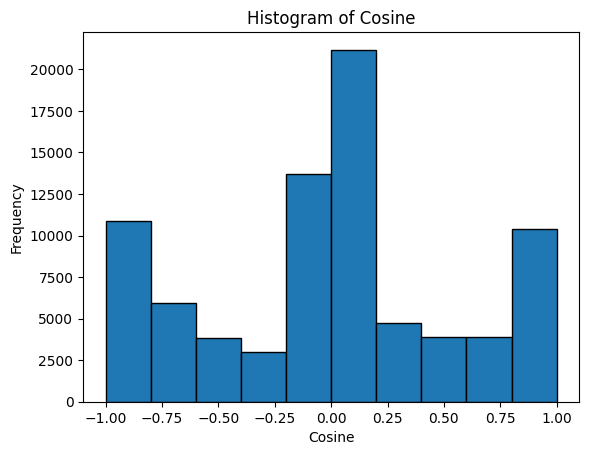

In [ ]:
plt.hist(cosine_list, bins=10, edgecolor='black')
plt.xlabel('Cosine')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine')
plt.show()

In [ ]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, cos in zip(vt_faces, cosine_list):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if -1 <= cos <= 1:
            color = color_bins[min(int((abs(cos)) * 10), 9)]
        else:
            color = (120, 120, 120)
        draw.polygon(vt_indices, outline=color, fill=color)
image.save(cosine_map_path)

In [ ]:
with open('cosine_result.py', 'w') as f:
  code = f"""
import bpy
bpy.ops.wm.open_mainfile(filepath = "{blender_file_path}")
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load("{cosine_map_path}")
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = "{cosine_result_path}")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P cosine_result.py
else:
  python_script = r'cosine_result.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")

Blender 4.2.0 (hash a51f293548ad built 2024-07-16 06:27:02)
Read blend: "/content/meshed_geometry.blend"
INFO Draco mesh compression is available, use library at /content/4.2/4.2/python/lib/python3.11/site-packages/libextern_draco.so
03:43:40 | INFO: Starting glTF 2.0 export
03:43:40 | INFO: Extracting primitive: Casting_Shot_8M0111257-1.001
03:43:41 | INFO: Primitives created: 1
03:43:41 | INFO: Finished glTF 2.0 export in 0.6327009201049805 s


Blender quit


In [ ]:
bins = 10
colors = [(int(255 * i / (bins - 1)), 0, int(255 * (1 - i / (bins - 1)))) for i in range(bins)]
ranges = [i / (bins - 1) for i in range(bins)]  # values from 0.0 to 1.0
with open(cosine_result_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()
bar_segments = "".join(
    f'<div style="height:30px; width:20px; background:#{r:02x}{g:02x}{b:02x};"></div>'
    for r, g, b in reversed(colors))
tick_labels = "".join(
    f'<div style="height:30px; font-size:12px;">cos(α) = {round(r, 2)}</div>'
    for r in reversed(ranges))
html = f"""
<div style="display:flex; justify-content:center; align-items:center;">
  <div style="display:flex; flex-direction:row; align-items:center;">
    <!-- Color bar and ticks on the left -->
    <div style="display:flex; flex-direction:row; align-items:center; margin-right:10px;">
      <div style="display:flex; flex-direction:column;">{bar_segments}</div>
      <div style="display:flex; flex-direction:column; margin-left:5px;">{tick_labels}</div>
    </div>
    <!-- 3D model viewer on the right -->
    <model-viewer src="data:model/gltf-binary;base64,{b64}"
                  auto-rotate camera-controls background-color="#fff"
                  style="width:600px; height:500px;">
    </model-viewer>
  </div>
</div>
<script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
"""
from IPython.display import HTML
HTML(html)

# Ejection coefficient result

In [ ]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, Phi in zip(vt_faces, Phi_list_optimize):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if 0 <= Phi <= max_Phi_optimize:
            color = color_bins[min(int((Phi / max_Phi_optimize) * 10), 9)]
        elif Phi < 0:
            color = (120, 120, 120)
        else:
            color = (0, 0, 0)
        draw.polygon(vt_indices, outline=color, fill=color)
image.save(ejection_coefficient_map_path)

In [ ]:
with open('ejection_coefficient_result.py', 'w') as f:
  code = f"""
import bpy
bpy.ops.wm.open_mainfile(filepath = "{blender_file_path}")
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load("{ejection_coefficient_map_path}")
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = "{ejection_coefficient_result_path}")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P ejection_coefficient_result.py
else:
  python_script = r'ejection_coefficient_result.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")

Blender 4.2.0 (hash a51f293548ad built 2024-07-16 06:27:02)
Read blend: "/content/meshed_geometry.blend"
INFO Draco mesh compression is available, use library at /content/4.2/4.2/python/lib/python3.11/site-packages/libextern_draco.so
03:43:44 | INFO: Starting glTF 2.0 export
03:43:44 | INFO: Extracting primitive: Casting_Shot_8M0111257-1.001
03:43:44 | INFO: Primitives created: 1
03:43:44 | INFO: Finished glTF 2.0 export in 0.44823241233825684 s


Blender quit


In [ ]:
bins = 10
colors = [(int(255 * i / (bins - 1)), 0, int(255 * (1 - i / (bins - 1)))) for i in range(bins)]
ranges = [i * max_Phi_optimize / (bins - 1) for i in range(bins)]
with open(ejection_coefficient_result_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()
bar_segments = "".join(
    f'<div style="height:30px; width:20px; background:#{r:02x}{g:02x}{b:02x};"></div>'
    for r, g, b in reversed(colors))
tick_labels = "".join(
    f'<div style="height:30px; font-size:12px;">Φ = {round(p, 2)}</div>'
    for p in reversed(ranges))
html = f"""
<div style="display:flex; justify-content:center; align-items:center; margin-top:10px;">
  <!-- Left: color bar and ticks -->
  <div style="display:flex; flex-direction:row; align-items:center; margin-right:20px;">
    <div style="display:flex; flex-direction:column;">{bar_segments}</div>
    <div style="display:flex; flex-direction:column; margin-left:5px;">{tick_labels}</div>
  </div>
  <!-- Center: 3D model viewer -->
  <model-viewer src="data:model/gltf-binary;base64,{b64}"
                auto-rotate camera-controls background-color="#fff"
                style="width:600px; height:500px;">
  </model-viewer>
  <!-- Right: Φ < 0 legend -->
  <div style="display:flex; flex-direction:column; align-items:left; margin-left:20px;">
    <div style="display:flex; align-items:center; gap:5px;">
      <div style="width:15px; height:15px; background:gray;"></div>
      <span style="font-size:14px;">Φ &lt; 0</span>
    </div>
  </div>
</div>
<script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
"""
from IPython.display import HTML
HTML(html)

# High ejection coefficient regions result

In [ ]:
image_size = 4000
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, Phi in zip(vt_faces, Phi_list_optimize):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if max_Phi_optimize * 0.99 <= Phi <= max_Phi_optimize:
            color = (0, 256, 0)
        else:
            color = (0, 0, 0)
        draw.polygon(vt_indices, outline=color, fill=color)
image_pil = Image.open(ejection_coefficient_map_path).convert("RGB")
image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
green_mask = cv2.inRange(cv_image, (0, 255, 0), (0, 255, 0))
kernel = np.ones((3, 3), np.uint8)
dilated_mask = cv2.dilate(green_mask, kernel, iterations=10)
dilated_image = np.zeros_like(cv_image)
dilated_image[dilated_mask == 255] = (0, 255, 0)
combined_image = image_cv.copy()
combined_image[dilated_mask == 255] = (0, 255, 0)
final_image_pil = Image.fromarray(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
final_image_pil.save(ejection_coefficient_mark_map_path)

In [ ]:
with open('ejection_coefficient_mark_result.py', 'w') as f:
  code = f"""
import bpy
bpy.ops.wm.open_mainfile(filepath = "{blender_file_path}")
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load("{ejection_coefficient_mark_map_path}")
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = "{ejection_coefficient_mark_result_path}")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P ejection_coefficient_mark_result.py
else:
  python_script = r'ejection_coefficient_mark_result.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")

Blender 4.2.0 (hash a51f293548ad built 2024-07-16 06:27:02)
Read blend: "/content/meshed_geometry.blend"
INFO Draco mesh compression is available, use library at /content/4.2/4.2/python/lib/python3.11/site-packages/libextern_draco.so
03:43:48 | INFO: Starting glTF 2.0 export
03:43:48 | INFO: Extracting primitive: Casting_Shot_8M0111257-1.001
03:43:48 | INFO: Primitives created: 1
03:43:48 | INFO: Finished glTF 2.0 export in 0.47955918312072754 s


Blender quit


In [ ]:
bins = 10
colors = [(int(255 * i / (bins - 1)), 0, int(255 * (1 - i / (bins - 1)))) for i in range(bins)]
tick_values = [i * max_Phi_optimize / (bins - 1) for i in range(bins)]
green_min = round(max_Phi_optimize * 0.99, 4)
green_max = round(max_Phi_optimize, 4)
with open(ejection_coefficient_mark_result_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()
bar_segments = ''.join(
    f'<div style="height:30px; width:20px; background:#{r:02x}{g:02x}{b:02x};"></div>'
    for r, g, b in reversed(colors))
tick_labels = ''.join(
    f'<div style="height:30px; font-size:12px;">Φ = {round(phi, 2)}</div>'
    for phi in reversed(tick_values))
html = f"""
<div style="display:flex; justify-content:center; align-items:center; margin-top:10px;">
  <!-- Vertical color bar + ticks -->
  <div style="display:flex; flex-direction:row; align-items:center; margin-right:20px;">
    <div style="display:flex; flex-direction:column;">{bar_segments}</div>
    <div style="display:flex; flex-direction:column; margin-left:5px;">{tick_labels}</div>
  </div>
  <!-- 3D model -->
  <model-viewer src="data:model/gltf-binary;base64,{b64}"
                auto-rotate camera-controls background-color="#fff"
                style="width:600px; height:500px;">
  </model-viewer>
  <!-- Right-side legends -->
  <div style="display:flex; flex-direction:column; align-items:flex-start; margin-left:20px; gap:10px; font-size:14px;">
    <div style="display:flex; align-items:center; gap:6px;">
      <div style="width:15px; height:15px; background:gray;"></div>
      Φ &lt; 0
    </div>
    <div style="display:flex; align-items:center; gap:6px;">
      <div style="width:15px; height:15px; background:green;"></div>
      {green_min} ≤ Φ ≤ {green_max}
    </div>
  </div>
</div>
<script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
"""
HTML(html)

# parting line result
### According to the ejection force equation for surfaces, the force reaches its maximum on the ejection side when the angle α equals 90 degrees. For regions closer to this 90-degree angle, a greater force is required to release the part from the die. Therefore, areas connecting the two halves should be oriented closest to 90 degrees, as these areas will experience the largest force necessary for release.

In [ ]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, cos in zip(vt_faces, cosine_list):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        color = (256, 256, 256) if cos > 0 else (256, 0, 0)
        draw.polygon(vt_indices, outline=color, fill=color)
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
red_mask = cv2.inRange(image, np.array([0, 0, 255]), np.array([0, 0, 255]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
kernel = np.ones((3, 3), np.uint8)
red_mask_cleaned_close = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel,iterations=1)
red_mask_cleaned_open = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel,iterations=1)
white_mask_cleaned_close = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel,iterations=1)
white_mask_cleaned_open = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel,iterations=1)
white_dilated = cv2.dilate(white_mask_cleaned_close + white_mask_cleaned_open - white_mask, kernel, iterations=1)
boundary_mask = cv2.bitwise_and(red_mask_cleaned_close + red_mask_cleaned_open - red_mask, white_dilated)
boundary_mask_cleaned_open = cv2.morphologyEx(boundary_mask, cv2.MORPH_OPEN, kernel,iterations=1)
boundary_mask_cleaned_close = cv2.morphologyEx(boundary_mask, cv2.MORPH_CLOSE, kernel,iterations=1)
output_image = np.zeros_like(image)
contours, _ = cv2.findContours(boundary_mask_cleaned_close - boundary_mask_cleaned_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(output_image, contours, -1, [0, 255, 0], thickness=2)
cv2.imwrite(parting_line_map_path, cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

True

In [ ]:
with open('parting_line_result.py', 'w') as f:
  code = f"""
import bpy
bpy.ops.wm.open_mainfile(filepath = "{blender_file_path}")
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load("{parting_line_map_path}")
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = "{parting_line_result_path}")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P parting_line_result.py
else:
  python_script = r'parting_line_result.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")

Blender 4.2.0 (hash a51f293548ad built 2024-07-16 06:27:02)
Read blend: "/content/meshed_geometry.blend"
INFO Draco mesh compression is available, use library at /content/4.2/4.2/python/lib/python3.11/site-packages/libextern_draco.so
03:43:50 | INFO: Starting glTF 2.0 export
03:43:50 | INFO: Extracting primitive: Casting_Shot_8M0111257-1.001
03:43:50 | INFO: Primitives created: 1
03:43:50 | INFO: Finished glTF 2.0 export in 0.499347448348999 s


Blender quit


In [ ]:
with open(parting_line_result_path, "rb") as f:
    glb_data = f.read()
b64_data = base64.b64encode(glb_data).decode()
html = f"""
<model-viewer src="data:model/gltf-binary;base64,{b64_data}"
              alt="GLB Model"
              auto-rotate
              camera-controls
              background-color="#fff"
              style="width: 100%; height: 500px;">
</model-viewer>
<script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
"""
HTML(html)